In [64]:
from curves import bsr_volatility
import numpy as np
import matplotlib.pyplot as plt

b = 2/3/10
a = 0.2*b
c = 0.1

### Plot instantaneous volatility at t and tau
Note that instantanous volatility at tau is the integral over the instantanous curve from T to tau.

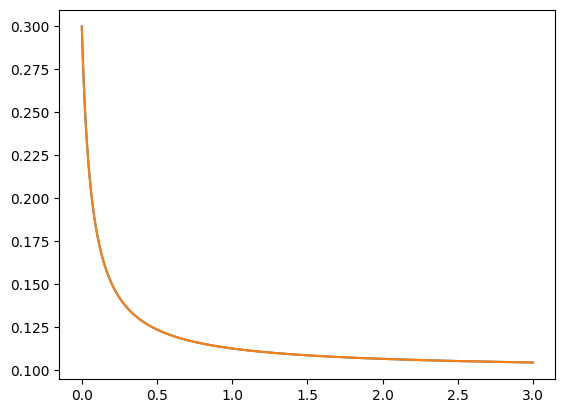

In [65]:

t = 0
T = 3
tau = 0.0001
dt = 1/365

times_tau = np.arange(tau, T, dt) 
times_t = np.arange(t, T, dt) 

vol_inst = bsr_volatility.sigma_instantanous(t, times_t, a, b, c)
vol_tau = bsr_volatility.sigma_brs(t, tau, times_tau, a,b,c) 

plt.plot(times_t, vol_inst)
plt.plot(times_tau, vol_tau)

## Test plugin-volatility
Testing that Black'76 plug-in volatility is equal to instantaneous volatility for small tau and small (T2-T1)

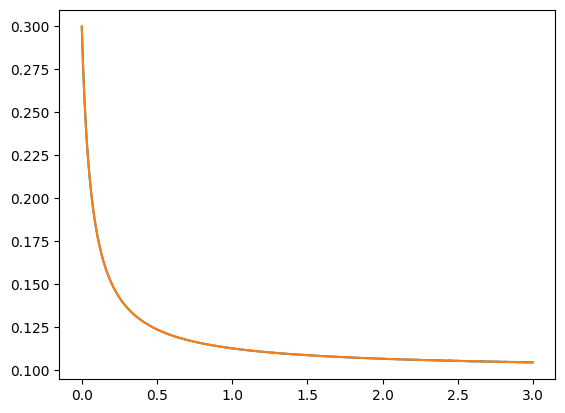

In [66]:
T = 3
t = 0
T1 = 0.1
T2 = 0.100001
tau = 0.000001


times_tau = np.arange(tau, T, dt) 

ve= bsr_volatility.sigma_plugin(t,tau, times_tau, times_tau+0.0001, a, b,c)
plt.plot(times_tau, ve)
plt.plot(times_t, vol_inst)


### Display Plugin volatility 

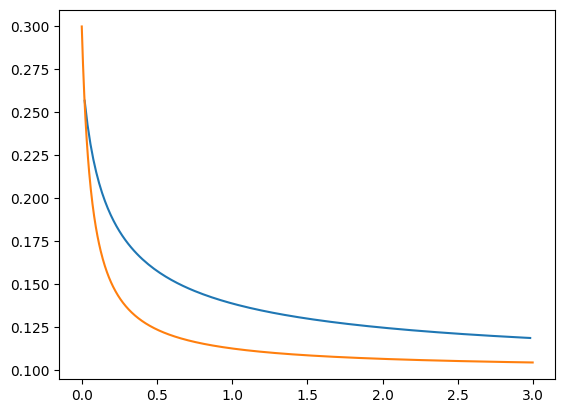

In [67]:
T = 3
t = 0
tau = 1/52

times_tau = np.arange(tau, T, tau) 

ve= bsr_volatility.sigma_plugin(t,times_tau, times_tau, times_tau+tau, a, b,c)
plt.plot(times_tau, ve)
plt.plot(times_t, vol_inst)

### Test consistency between total volatility and the 3 factors

In [68]:

t = 0
T = 1 
tau =1/52

vol = bsr_volatility.sigma_brs(t, tau, T, a,b,c)

print("volatility:"+ str(vol))
print("Variance:"+ str(vol**2))

f1 = bsr_volatility.sigma_factor1(t, tau, T, a,b)
f2 = bsr_volatility.sigma_factor2(t, tau, T, a,b,c)
f3 = bsr_volatility.sigma_factor3(t, tau, T, c)

print("SumVariance: "+ str((f1**2+f2**2+f3**2)))

volatility:0.11261407268633895
Variance:0.012681929367004033
SumVariance: 0.012681929367004035


## Simulation

### One factor

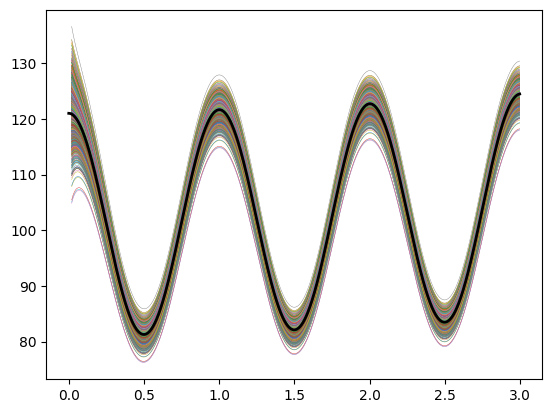

In [69]:
# Parameters 

from math import sqrt


n_sims = 1000  # Number of paths to simulate
T = 3  # Total time in years
dt = 1/365  # Daily time step for display
#n_steps = int(T / dt)
tau = 1/52

times = np.arange(0, T, dt)   # Time steps
times_tau = np.arange(tau, T, dt) 

# Generate independent random samples
w = np.random.randn(n_sims, 1)

term_structure_initial = bsr_volatility.term_structure(times)
term_structure_tau = bsr_volatility.term_structure(times_tau)

vol_tau = bsr_volatility.sigma_brs(t, tau, times_tau, a,b,c)

z = np.exp(vol_tau * w * sqrt(tau)- 0.5 * vol_tau**2*tau) 

sim_curves = z *  term_structure_tau

# Plot each row as a separate line
for i, row in enumerate(sim_curves):
    plt.plot(times_tau,row, label=f'Row {i+1}', lw=0.3)
    
plt.plot(times,term_structure_initial, color='black', lw=2, label='Term Structure')
#plt.plot(times,sigma_brs(t, t+dt, taus, a,b,c), color='black', lw=2, label='Term Structure')


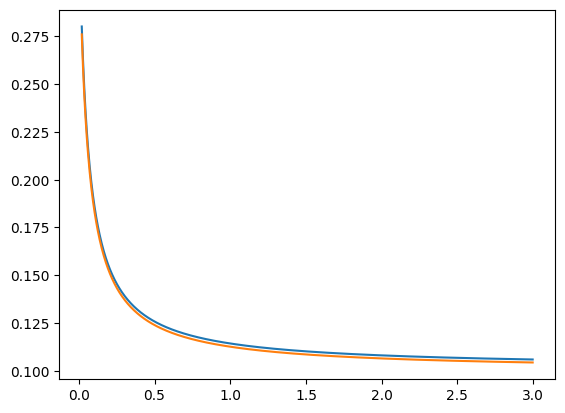

In [70]:
returns = np.log(z)
std_return = np.std(returns, axis = 0) *np.sqrt(1/tau)

plt.plot(times_tau, std_return)
plt.plot(times_tau, vol_tau)

## 3-Factor BSR (HJM) Simulation

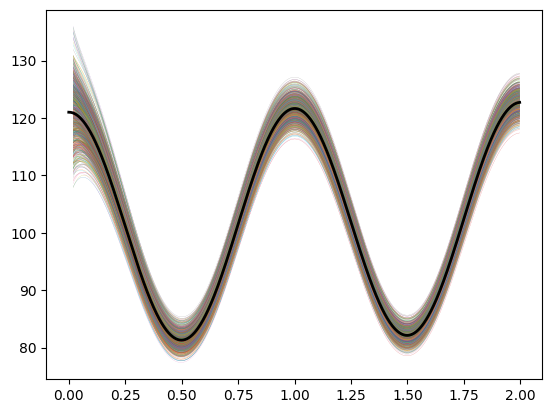

In [71]:
# Parameters 

n_sims = 1000  # Number of paths to simulate
T = 2  # Total time in years
dt = 1/365  # Daily time step
#n_steps = int(T / dt)
tau = 1/52

times = np.arange(0, T, dt)   # Time steps
times_tau = np.arange(tau, T, dt) 

vol_tau = bsr_volatility.sigma_brs(t, tau, times_tau, a,b,c)

# Generate independent random samples
w = np.random.randn(n_sims, 3)

term_structure_initial = bsr_volatility.term_structure(times)  # initial term structure
term_structure_tau = bsr_volatility.term_structure(times_tau)  # slice of initial term structure starting at

f1 = bsr_volatility.sigma_factor1(t, tau, times_tau, a,b)
f2 = bsr_volatility.sigma_factor2(t, tau, times_tau, a,b,c)
f3 = bsr_volatility.sigma_factor3(t, tau, times_tau, c)

z1 = np.exp(np.outer(w[:,0],f1) * np.sqrt(tau) - 0.5 * f1**2*tau) 
z2 = np.exp(np.outer(w[:,1],f2) * np.sqrt(tau) - 0.5 * f2**2*tau) 
z3 = np.exp(np.outer(w[:,2],f3) * np.sqrt(tau) - 0.5 * f3**2*tau) 
Z = z1*z2*z3

sim_curves = Z *  term_structure_tau

# Plot each row as a separate line
for i, row in enumerate(sim_curves):
    plt.plot(times_tau,row, label=f'Row {i+1}', lw = 0.1)
    
plt.plot(times,term_structure_initial, color='black', lw=2, label='Term Structure')
#plt.plot(times,sigma_brs(t, t+dt, taus, a,b,c), color='black', lw=2, label='Term Structure')



### Check 3-factor simulation consistency
Note that it needs 10000 simulation to fit volatility accurately

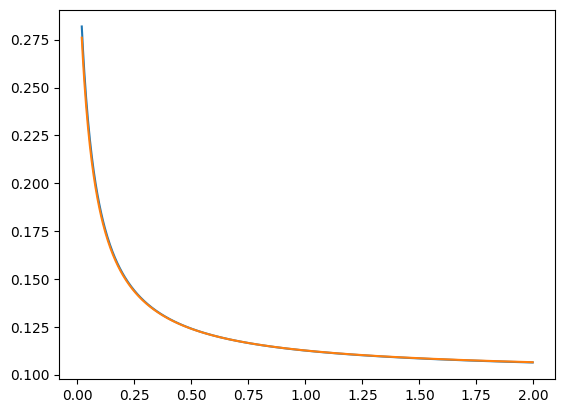

In [72]:
f_returns = np.log(Z)
std_sim_f_returns = np.std(f_returns, axis = 0) *np.sqrt(1/tau)

plt.plot(times_tau, std_sim_f_returns)
plt.plot(times_tau, vol_tau)


## Cashflow at Risk

### Volatility structure at each forward step
It is important to note that the spot volatility in the BSR framework is not constant, but a falling convex function of time.
In the example below. The volatility term structure for each step in a weekly simulation is displayed

0.24021092869136088

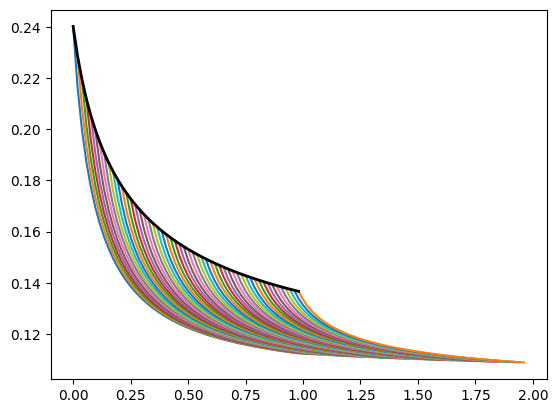

In [73]:
dt = 1/52
T = 1


initial_times = np.arange(0, T, dt)   # Time steps
vol = [0] * initial_times

for i, t in enumerate(initial_times):
    step_times = initial_times + t
    sigma = bsr_volatility.sigma_brs(0, t+dt, step_times+dt+dt, a,b,c)
    vol[i] = sigma[0]
    plt.plot(step_times, sigma)

plt.plot(initial_times, vol, color='black', lw=2, label='Term Structure')

bsr_volatility.sigma_brs(0, dt, dt+dt, a,b,c)

### Cashflow at Risk (1-factor) Updating volatility

Using single factor and updating volatility structure at each step

In [74]:

# Notes:
# Simulation of cashflow by updating volatility structure at each time step.
# Using shocks directly, not cumprod.This gives correct volatility.
# Possible that alternative solution would be to use initial volatility structure 
# and cumulate shocks.

dt = 1/52
T = 1

n_sims = 1000

initial_times = np.arange(0, T, dt)   # Time steps
n_steps = len(initial_times)

w = np.random.randn(n_sims, len(initial_times))

shocks = np.zeros((n_sims, n_steps))
changes =  np.zeros((n_sims, n_steps))

for i, t in enumerate(initial_times):
    step_times = initial_times + t
    sigma = bsr_volatility.sigma_brs(0, t+dt, step_times+dt+dt, a,b,c) # Update the volatility
    shocks[:,i] = np.exp(sigma[0] * w[:,i] * np.sqrt(dt)- 0.5 * sigma[0]**2*dt) 


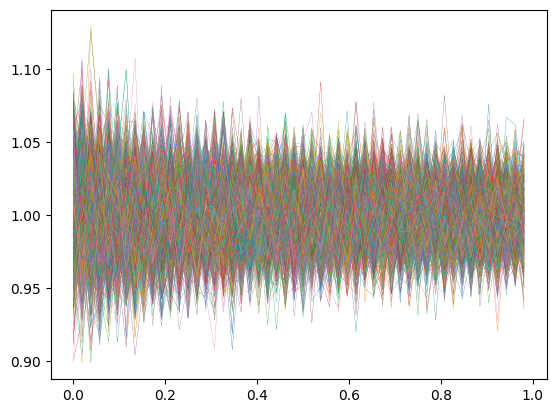

In [75]:
for i, t in enumerate(shocks):
    plt.plot(initial_times, shocks[i,:], lw = 0.2)

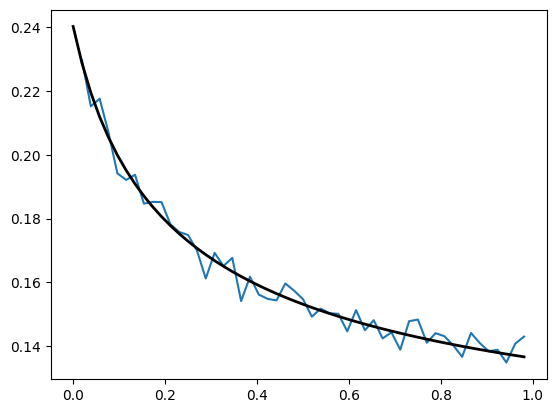

In [78]:

cum_shocks = np.cumprod(shocks,axis =1)
cum_returns = np.log(cum_shocks[:,1:]/cum_shocks[:,:-1])
std_cum_returns = np.std(cum_returns, axis = 0) *np.sqrt(1/dt)


plt.plot(initial_times[1:], std_cum_returns)
plt.plot(initial_times, vol, color='black', lw=2, label='Term Structure')
